# <center> Optimisation problem in the voter model

In [3]:
import sys
import numpy as np
import pickle
from time import time
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.lines import Line2D
from matplotlib import cm
import util

# for plots appearance
color = ["blue", "red", "green", "orange", "pink", "cyan"]
letter = "abcdefghijklmnopqrstuvwxyz"
marker = "x+*^po"
linestyle = ["--", "-.", ":", "-", (0,(3, 5, 1, 5)), "--"] # last one is dashdotdotted 
            #from https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/linestyles.html

# latex rendering
rc('font',**{'family':'sans-serif','sans-serif':['Palatino']})
rc('text', usetex=True)
rc('legend', frameon=False) # PS doesn't do well with transparencies

## Optim with backfire effect (no time constraint)

In [4]:
n = 100
lambda_range = np.array([0.3, 0.5, 0.7]) # heterogeneity
z0_range = np.arange(n)
alpha_range = np.array([.025, .05, 0.075, .1]) # backfire effect intensity
with_max = True # do we use a z1_max?

Z1 = np.zeros((alpha_range.size, z0_range.size, lambda_range.size))
for k,lambd in enumerate(lambda_range):
    for i,alpha in enumerate(alpha_range):
        for j,z0 in enumerate(z0_range):
            D = 1-lambd-lambd*alpha*z0
            if D <= 0:
                Z1[i,j,k] = -1
            else:
                z1 = lambd*z0/D
                if with_max:
                    z1_max = (n-z0)/(1+alpha*z0)
                    Z1[i,j,k] = min(z1_max, z1)
                else:
                    Z1[i,j,k] = z1

Plot.

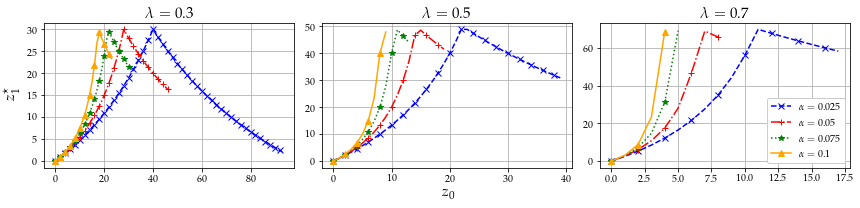

In [5]:
fs = 15 # fontsize
fig, ax = plt.subplots(1, 3, figsize=(12,3))

for k,lambd in enumerate(lambda_range):
    for i,alpha in enumerate(alpha_range):
        idx, = np.where(Z1[i,:,k]!=-1)
        ax[k].plot(z0_range[idx], Z1[i,idx,k], marker=marker[i], ls=linestyle[i], color=color[i], markevery=2, label=r"$\alpha={}$".format(alpha))
    ax[k].grid()
    ax[k].set_title(r"$\lambda={}$".format(lambd), fontsize=fs)
    
# style
ax[0].set_ylabel(r"$z_1^\star$", fontsize=fs)
ax[1].set_xlabel(r"$z_0$", fontsize=fs)
ax[2].legend(loc="lower right", frameon=True, framealpha=1)
    
# save and show
plt.tight_layout()
plt.savefig("results/optim_backfire.eps")
plt.show()
plt.close()

We do it again but now we use zmax in the cases where D<=0 and look at the discrepancy between the resulting diversity and lambda.

In [6]:
error = np.zeros((alpha_range.size, z0_range.size, lambda_range.size))
for k,lambd in enumerate(lambda_range):
    for i,alpha in enumerate(alpha_range):
        for j,z0 in enumerate(z0_range):
            D = 1-lambd-lambd*alpha*z0
            if D <= 0:
                zm = (n-z0)/(1+alpha*z0) # z1_max
                error[i,j,k] = np.abs(lambd - zm/((1+alpha*zm)*z0+zm))
            else:
                continue # error is already 0 from the way we initialised

Plot.

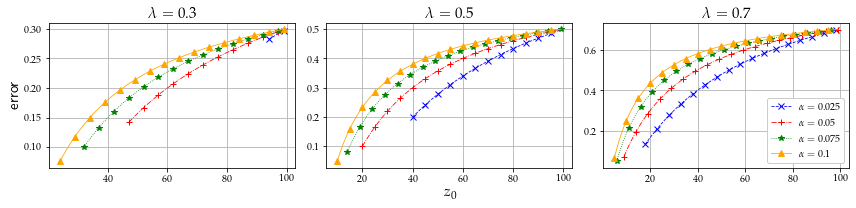

In [13]:
fs = 15 # fontsize
fig, ax = plt.subplots(1, 3, figsize=(12,3))

for k,lambd in enumerate(lambda_range):
    for i,alpha in enumerate(alpha_range):
        idx, = np.where(Z1[i,:,k]==-1)
        ax[k].plot(z0_range[idx], error[i,idx,k], marker=marker[i], markevery=5, lw=.8, ls=linestyle[i], color=color[i], label=r"$\alpha={}$".format(alpha))
    ax[k].grid()
    ax[k].set_title(r"$\lambda={}$".format(lambd), fontsize=fs)
    
# style
ax[0].set_ylabel(r"error", fontsize=fs)
ax[1].set_xlabel(r"$z_0$", fontsize=fs)
ax[2].legend(loc="lower right", frameon=True, framealpha=1)
    
# save and show
plt.tight_layout()
plt.savefig("results/optim_backfire_error.eps")
plt.show()
plt.close()

## Optim time constraint with backfire

Choose parameters.

In [2]:
n = 100
z0 = 15
alpha = .05
zmax = int((n-z0)/(1+alpha*z0))
lambd_range = np.array([.1, .25, .5, .7, .75])
T_range = np.arange(1,30)

Compute greedy algo.

In [3]:
z1_opti = np.zeros((lambd_range.size, T_range.size))
times = z1_opti.copy()
n_iters = z1_opti.copy()

start = time()
for i,lambd in enumerate(lambd_range):
    for j,T in enumerate(T_range):
        sys.stdout.flush()
        sys.stdout.write("lambd {}/{} --- T {}/{} --- elapsed time {:.3f}\r"
                         .format(i+1, lambd_range.size, j+1, T_range.size, time()-start))
        z1_opti[i,j], times[i,j], n_iters[i,j] = util.greedy_optim_backfire(n,z0,lambd,alpha,zmax,T)

Plot result.

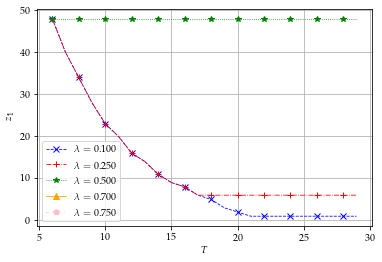

In [4]:
#fig, ax = plt.subplots(1, lambd_range.size, figsize=(15,3))
for i,lambd in enumerate(lambd_range):
        
    # we only plot the cases where a solution was found
    idx, = np.where(z1_opti[i,:]!=-1)
    x, y = T_range[idx], z1_opti[i,idx]
    plt.plot(x, y, marker=marker[i], markevery=2, ls=linestyle[i], lw=.8, color=color[i], label=r"$\lambda={:.3f}$".format(lambd))
        
# appearance
#plt.hlines(util.z1_ideal(z0,lambd), T_range[0], T_range[-1], color=color[i+1], ls=linestyle[i+1], label=r"ideal $z_1$")
plt.xlabel(r"$T$")
plt.ylabel(r"$z_1$")
plt.grid()
plt.legend(loc="best", frameon=True)
    
# save and show
#plt.savefig(f"optim_backfire_n={n}_z0={z0}_alpha={alpha}.pdf")
plt.show()
plt.close()

## 1) Plot cv time using the coalesce formula

The formula only depends upon the sum $z:=z_0+z_1$; we plot for $z=0, \ldots, n$.

In [2]:
n = 100
z_range = np.arange(1,n)
cv_time, bound = np.array([]), np.array([])
for z in z_range:
    cv_time = np.append(cv_time, util.coalesce_cvtime(n,z))
    bound = np.append(bound, util.bound_cvtime(n,z))

/Users/antoinevendeville/Documents/UCL/AntoinePhD/python/util.py:261: RuntimeWarning: divide by zero encountered in double_scalars
  return np.exp(1)*(1+np.log(n-z))*(n-1)/(z-1)


Fit with exponential regression.

In [5]:
deg = 9
coeff = np.polyfit(z_range, np.log(cv_time), deg)
coeff = np.flip(coeff)
print(coeff)
def fit(z):
    sum_tmp = 0
    for d in range(deg+1):
        sum_tmp += coeff[d] * z**(d)
    return np.exp(sum_tmp)

[ 5.47336278e+00 -5.13303482e-01  5.61238006e-02 -3.76212480e-03
  1.52139661e-04 -3.80913857e-06  5.93584644e-08 -5.59618396e-10
  2.91873546e-12 -6.46010106e-15]


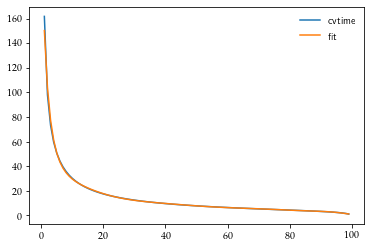

In [6]:
plt.plot(z_range, cv_time, label="cvtime")
plt.plot(z_range, [fit(z) for z in z_range], label="fit")
plt.legend()
#plt.loglog(z_range, bound)

## 2) CV time with backfire effect

In [64]:
n = 100
z0 = 25
lambd = .01 # backfire effect intensity

z1_range = np.arange(n+1)
cv_time, bound = np.array([]), np.array([])
for z1 in z1_range:
    z0_tmp = int(z0 + round(alpha*z1*z0))
    z = z1+ z0_tmp
    cv_time = np.append(cv_time, util.coalesce_cvtime(n,z))
    bound = np.append(bound, util.bound_cvtime(n,z))

/Users/antoinevendeville/Documents/UCL/AntoinePhD/python/util.py:261: RuntimeWarning: divide by zero encountered in log
  return np.exp(1)*(1+np.log(n-z))*(n-1)/(z-1)


Plot.

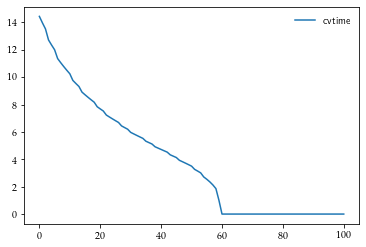

In [65]:
plt.plot(z1_range, cv_time, label="cvtime")
plt.legend()

## 4) Backfire effect: $z_1^\star$ function of $z_0$ for different values of $\alpha$

Compute D for various $\lambda$ and $\alpha z_0$.

In [32]:
n = 100
lambd = .5
alpha_range = np.array([.025, .05, 0.075, .1])
z0_range = np.arange(50)
Z1 = np.empty((alpha_range.size, z0_range.size))
for i,alpha in enumerate(alpha_range):
    for j,z0 in enumerate(z0_range):
        D = 1-lambd-lambd*alpha*z0
        if D <= 0:
            Z1[i,j] = -1
        else:
            z1 = lambd*z0/D
            z1_max = (n-z0)/(1+alpha*z0)
            Z1[i,j] = min(z1_max, z1)

Plot.

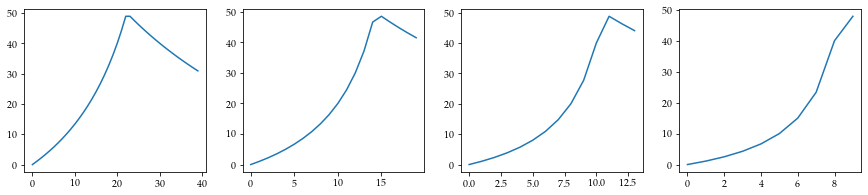

In [37]:
fig, ax = plt.subplots(1, alpha_range.size, figsize=(15,3))
for i,alpha in enumerate(alpha_range):
    idx, = np.where(Z1[i,:]!=-1)
    z1_tmp = Z1[i,idx]
    z0_range_tmp = z0_range[idx]
    ax[i].plot(z0_range_tmp, z1_tmp)
plt.show()
plt.close()

## Optim time constraint no backfire

Choose parameters.

In [14]:
n = 100
z0 = 15
zmax = n-z0
lambd_range = np.array([.1, .25, .5, .7, .75])
T_range = np.arange(1,30)

Compute greedy algo.

In [15]:
z1_opti = np.zeros((lambd_range.size, T_range.size))
times = z1_opti.copy()
n_iters = z1_opti.copy()

start = time()
for i,lambd in enumerate(lambd_range):
    for j,T in enumerate(T_range):
        sys.stdout.flush()
        sys.stdout.write("lambd {}/{} --- T {}/{} --- elapsed time {:.3f}\r"
                         .format(i+1, lambd_range.size, j+1, T_range.size, time()-start))
        z1_opti[i,j], times[i,j], n_iters[i,j] = util.greedy_optim(n,z0,lambd,zmax,T)

Plot result.

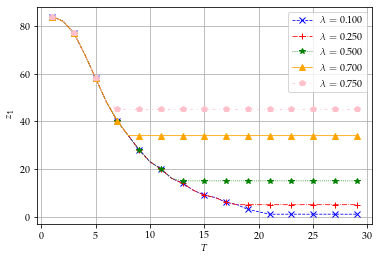

In [16]:
#fig, ax = plt.subplots(1, lambd_range.size, figsize=(15,3))
for i,lambd in enumerate(lambd_range):
        
    # we only plot the cases where a solution was found
    idx, = np.where(z1_opti[i,:]!=-1)
    x, y = T_range[idx], z1_opti[i,idx]
    plt.plot(x, y, marker=marker[i], markevery=2, ls=linestyle[i], lw=.8, color=color[i], label=r"$\lambda={:.3f}$".format(lambd))
        
# appearance
#plt.hlines(util.z1_ideal(z0,lambd), T_range[0], T_range[-1], color=color[i+1], ls=linestyle[i+1], label=r"ideal $z_1$")
plt.xlabel(r"$T$")
plt.ylabel(r"$z_1$")
plt.grid()
plt.legend(loc="best", frameon=True)
    
# save and show
plt.savefig(f"optim_n={n}_z0={z0}.pdf")
plt.show()
plt.close()

## Legacy

Define the greedy algorithm using mixing time.

In [51]:
def greedy_mixing(n,z0,lambd,zmax,T,eps,spacing):
    # function to calculate mixing time
    def cv_calc(z1):
        Q = util.Qmatrix(n,z0,z1)
        pi = util.stationary(n,z0,z1,Q)
        return util.mixing_time(n, z1, z0, z1, Q, pi, eps, spacing) # we take n1=z1
    # init
    z1 = int(z0*lambd/(1-lambd))
    t = cv_calc(z1)
    # iter
    n_iter = 0
    while t>T or z1>zmax:
        if t>T and z1>zmax:
            print("impossible")
            break
        elif t>T and z1<=zmax:
            z1 += 1
        elif t<=T and z1>zmax:
            z1 -= 1
        else:
            print("oops")
            break
        n_iter += 1 
        t = cv_calc(z1)
    # end
    return z1, t, n_iter